In [1]:
import pandas as pd
from minicons import scorer
from tqdm import tqdm
import ipdb
from ast import literal_eval
import numpy as np
from humor_detection.util import load_sentences

tqdm.pandas()
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid', context='notebook', rc={'figure.figsize':(15,10), 'font.family': 'FreeSerif'}, font_scale=2.5)

/home/venkat/Desktop/bulwer/.venv/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
sents = load_sentences('combo-test-pos')
sents = [x.capitalize() for x in sents]

In [3]:
len(sents), random.sample(sents, 5)

(5416,
 ['I bet when you barge in on a chicken rapist and say guess what they really mean it when they say chicken butt',
  'Did you hear about the miners new album i really dig it',
  'Police found a criminal shot to death with exit wounds but no entry wounds it was an inside job',
  'I used to be a comedian back in newfoundland but i got sick of having to explain the jokes',
  'Russian agent disgusted with things he forced to do to pass self off as reddit commenter'])

In [5]:
with open('data/crowd-sample.txt', 'r', encoding='utf-8') as f: 
    crowd_sents = [x.strip() for x in f.readlines()]
len(crowd_sents)

1000

In [6]:
bl = pd.read_csv('data/Bulwer-Lytton.tsv', sep='\t', quoting=3)

In [7]:
len(''.join(sents)), len(''.join(bl.sentence.values.tolist()))

(466077, 568949)

In [9]:
lm = scorer.IncrementalLMScorer('google/gemma-3-1b-pt', device='cuda')

In [10]:
vocab_size = lm.tokenizer.vocab_size
print(vocab_size)

262144


In [11]:
def token_scores(lm, sents, batch_size=32):
    token_scores = []
    for i in tqdm(range(0, len(sents), batch_size)):
        batch = sents[i:i+batch_size]
        token_scores.append(lm.token_score(batch, rank=True))

    return sum(token_scores, [])

In [12]:
df = pd.DataFrame({
    'sent': bl.sentence.values.tolist()+sents+crowd_sents,
    'type': ['BL' for _ in range(len(bl))] + ['combo-humor' for _ in range(len(sents))] + ['crowd-first' for _ in range(len(crowd_sents))]
})
df.shape

(8194, 2)

In [13]:
df['token_scores'] = token_scores(lm, df.sent.values.tolist())
df['log_probs'] = df.token_scores.apply(lambda x: [a[1] for a in x])
df['ranks'] = df.token_scores.apply(lambda x: [a[2] for a in x][1:])

100%|████████████████████████████████████████████████████████████████████████████| 257/257 [01:35<00:00,  2.70it/s]


In [20]:
def make_outlier_dist(sents, vocab_size):
    '''
    Given a list of sentences with their token ranks, this function returns a 2D distribution 
    of outlier points. Outliers can be calculated over the whole distribution or per sentence
    '''
    points = []
    #outlier_value = np.percentile(sum(sents, []), outlier)
    #median_rank = np.percentile(sum(sents, []), 50)
    #std_rank = np.std(sum(sents, []))
        # print(f"Median rank: {np.round(median_rank,2)} SD: {np.round(std_rank, 2)} Outlier: {outlier_value}")
    for sent in sents:
        # if per_sent:
        # outlier_value = np.percentile(sent, outlier)
            
        # if outlier_type=='rank':
        relevant_inds = [(i,y) for i,y in enumerate(sent) if y>1000]
        ys = [y/vocab_size for _,y in relevant_inds]
        # else:
            # relevant_inds = [(i,y) for i,y in enumerate(sent) if outlier_value>y]
            # ys = [y for _,y in relevant_inds]

        xs = [i/len(sent) for i,_ in relevant_inds]
        points += [(x,y) for (x,y) in zip(xs, ys)]
    points = pd.DataFrame(np.array(points),columns=['sent-pos', 'rank'])

    return points

In [25]:
num_bl_tokens=len(sum(df[df.type=='BL'].ranks.values.tolist(), []))
num_comb_tokens=len(sum(df[df.type=='combo-humor'].ranks.values.tolist(), []))
num_crowd_tokens=len(sum(df[df.type=='crowd-first'].ranks.values.tolist(), []))
print(num_bl_tokens, num_comb_tokens, num_crowd_tokens)

125357 100959 24985


Fraction of outlier BL tokens:  0.072
Fraction of outlier comb tokens:  0.108
Fraction of outlier crowd tokens:  0.073


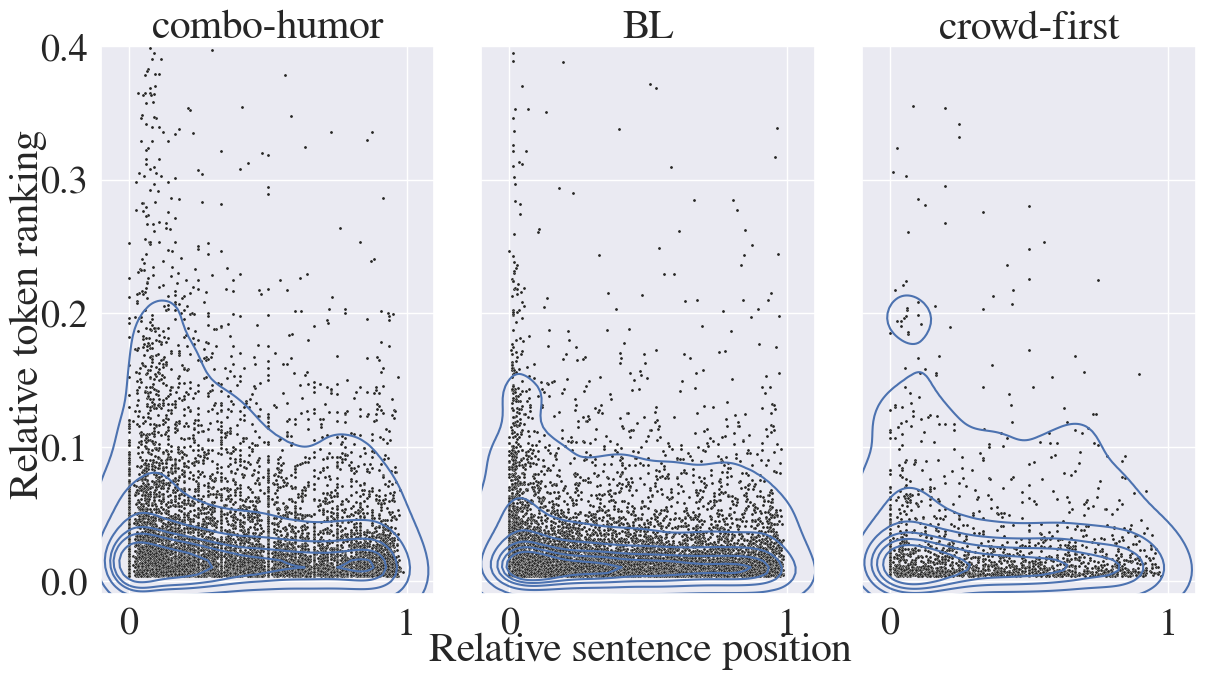

In [26]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 7))

# Flatten the 2D array of axes for easier iteration
axes_flat = axes.flatten()

bull_dist = make_outlier_dist(df[df.type=='BL'].ranks.values.tolist(), vocab_size=vocab_size)
print("Fraction of outlier BL tokens: ", np.round(bull_dist.shape[0]/num_bl_tokens, 3))

comb_dist = make_outlier_dist(df[df.type=='combo-humor'].ranks.values.tolist(), vocab_size=vocab_size)
print("Fraction of outlier comb tokens: ", np.round(comb_dist.shape[0]/num_comb_tokens, 3))

crowd_dist = make_outlier_dist(df[df.type=='crowd-first'].ranks.values.tolist(), vocab_size=vocab_size)
print("Fraction of outlier crowd tokens: ", np.round(crowd_dist.shape[0]/num_crowd_tokens, 3))

dists = [{'name': 'combo-humor', 'dist': comb_dist}, 
         {'name': 'BL', 'dist': bull_dist},
         {'name': 'crowd-first', 'dist': crowd_dist}
        ]

# Create plots in each subplot
for idx, (ax, dist) in enumerate(zip(axes_flat, dists)):
    sns.scatterplot(dist['dist'],x='sent-pos', y='rank', s=5, color=".15", ax=ax)
    # sns.histplot(points,x=x, y=y, bins=50, pthresh=.1, cmap="mako")
    sns.kdeplot(dist['dist'],x='sent-pos', y='rank', levels=7, linewidths=1.5,ax=ax)
    # Optional: Add title to each subplot
    ax.set_title(f"{dist['name']}")

    # Set axis limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.01,0.4)
    
    ax.set_xlabel('')    
    # Remove y ticks and labels for right column
    if idx!=0:
        ax.set_yticklabels([])
    ax.set_ylabel('')

# Add common x and y labels
# Adjust the layout
plt.tight_layout()
# Adjust margins to accommodate the common labels
plt.subplots_adjust(left=0.05, bottom=0.1)
fig.text(0.5, 0.02, 'Relative sentence position', ha='center', va='center')
fig.text(-0.01, 0.5, 'Relative token ranking', ha='center', va='center', rotation='vertical')
plt.savefig('surprisal.png', dpi=300, bbox_inches='tight')

In [ ]:
comb_dist.shape, bull_dist.shape

In [27]:
with open('fewshot-generation/outputs/gpt5-sents.txt', 'r', encoding='utf-8') as f: 
        gpt5_sents = [x.strip() for x in f.readlines()]

with open('fewshot-generation/outputs/gpt41-sents.txt', 'r', encoding='utf-8') as f: 
        gpt4_sents = [x.strip() for x in f.readlines()]

with open('fewshot-generation/outputs/DeepSeek_sents.txt', 'r', encoding='utf-8') as f: 
        deep_sents = [x.strip() for x in f.readlines()]

with open('fewshot-generation/outputs/gpt-120b_temp_1.txt', 'r', encoding='utf-8') as f: 
        gpt120_sents = [x.strip() for x in f.readlines()]

syn_df = pd.DataFrame(
    {'type': (['gpt5' for _ in range(len(gpt5_sents))] + 
             ['gpt4' for _ in range(len(gpt4_sents))] + 
             ['deep' for _ in range(len(deep_sents))] +
             ['gpt120' for _ in range(len(gpt120_sents))]),
    'sent': gpt5_sents+gpt4_sents+deep_sents+gpt120_sents})

In [28]:
syn_df['token_scores'] = token_scores(lm, syn_df.sent.values.tolist())
syn_df['log_probs'] = syn_df.token_scores.apply(lambda x: [a[1] for a in x])
syn_df['ranks'] = syn_df.token_scores.apply(lambda x: [a[2] for a in x][1:])

100%|████████████████████████████████████████████████████████████████████████████| 125/125 [02:02<00:00,  1.02it/s]


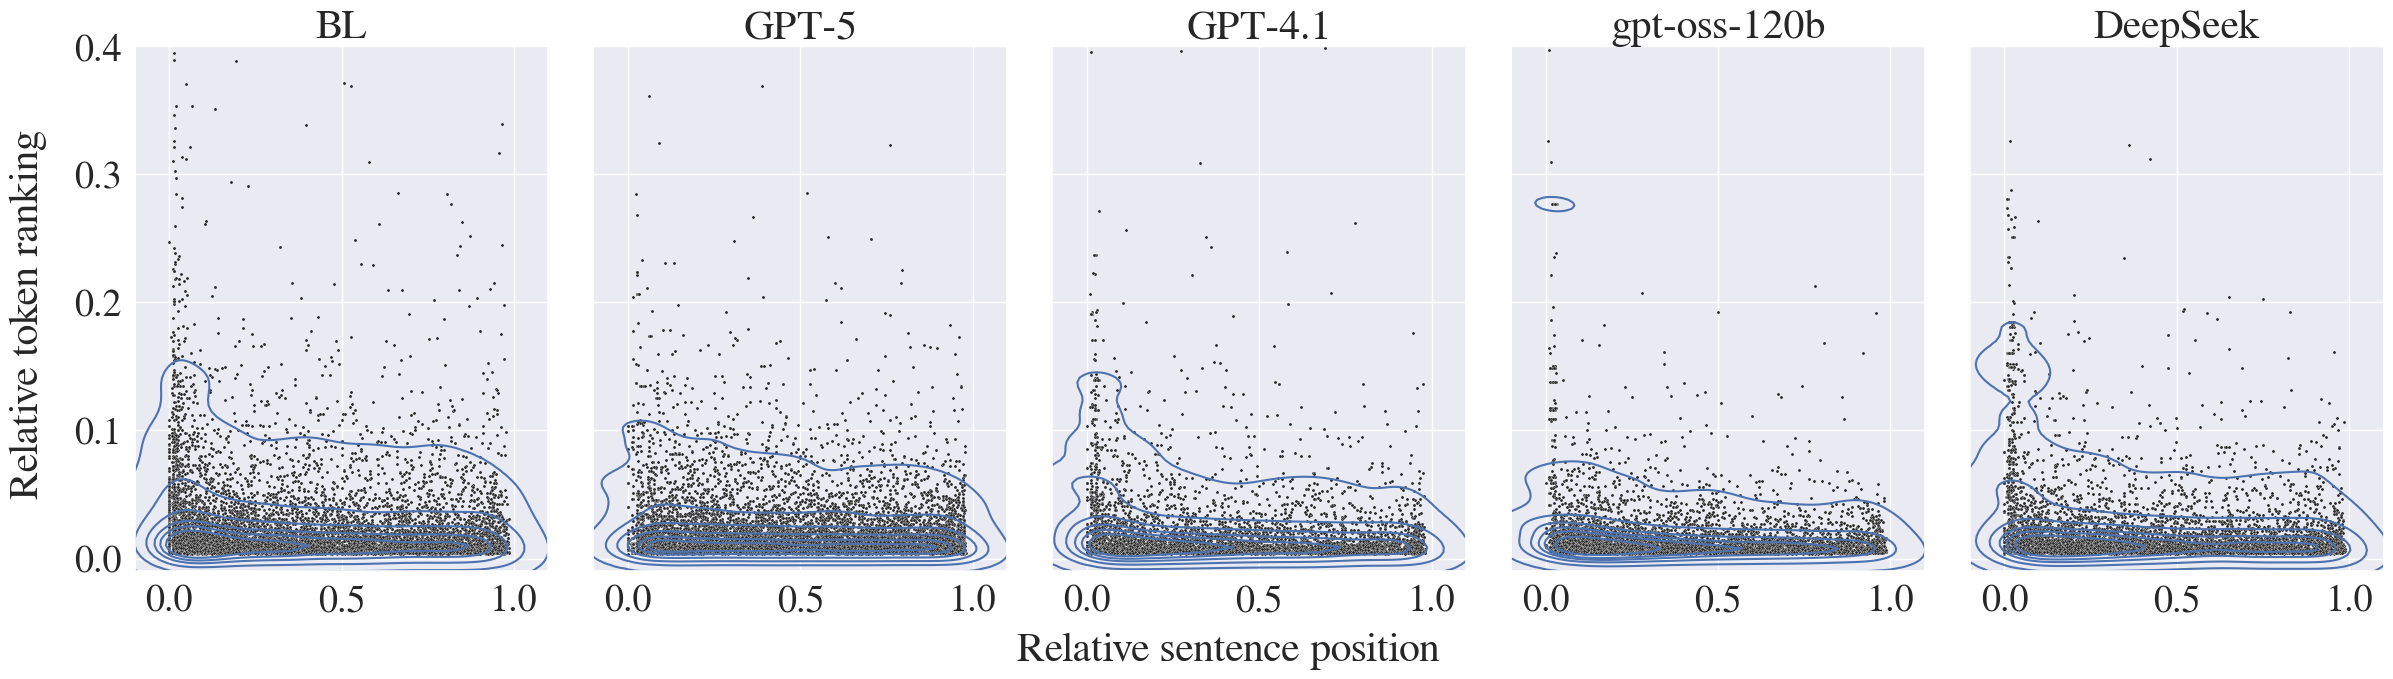

In [35]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(1, 5, figsize=(24, 7))

# Flatten the 2D array of axes for easier iteration
axes_flat = axes.flatten()

gpt5_dist = make_outlier_dist(syn_df[syn_df.type=='gpt5'].ranks.values.tolist(), vocab_size=vocab_size)
gpt4_dist = make_outlier_dist(syn_df[syn_df.type=='gpt4'].ranks.values.tolist(), vocab_size=vocab_size)
gpt120_dist = make_outlier_dist(syn_df[syn_df.type=='gpt120'].ranks.values.tolist(), vocab_size=vocab_size)
deep_dist = make_outlier_dist(syn_df[syn_df.type=='deep'].ranks.values.tolist(), vocab_size=vocab_size)

dists = [{'name': 'BL', 'dist': bull_dist},
        {'name': 'GPT-5', 'dist': gpt5_dist}, 
         {'name': 'GPT-4.1', 'dist': gpt4_dist},
         {'name': 'gpt-oss-120b', 'dist': gpt120_dist}, 
         {'name': 'DeepSeek', 'dist': deep_dist}
        ]

# Create plots in each subplot
for idx, (ax, dist) in enumerate(zip(axes_flat, dists)):
    
    sns.scatterplot(dist['dist'],x='sent-pos', y='rank', s=5, color=".15", ax=ax)
    # sns.histplot(points,x=x, y=y, bins=50, pthresh=.1, cmap="mako")
    sns.kdeplot(dist['dist'],x='sent-pos', y='rank', levels=7, linewidths=1.5,ax=ax)
    # Optional: Add title to each subplot
    ax.set_title(f"{dist['name']}")

    # Set axis limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.01,0.4)
    
    ax.set_xlabel('')    
    # Remove y ticks and labels for right column
    if idx!=0:
        ax.set_yticklabels([])
    ax.set_ylabel('')

# Add common x and y labels
# Adjust the layout
plt.tight_layout()
# Adjust margins to accommodate the common labels
# plt.subplots_adjust(left=0.05, bottom=0.1)
fig.text(0.5, 0.02, 'Relative sentence position', ha='center', va='center')
fig.text(-0.00001, 0.5, 'Relative token ranking', ha='center', va='center', rotation='vertical')
plt.savefig('surprisal-syn.png', dpi=300, bbox_inches='tight')

Fraction of outlier BL tokens:  0.072
Fraction of outlier crowd tokens:  0.073
Fraction of outlier comb tokens:  0.108
Fraction of outlier GPT5 tokens:  0.124
Fraction of outlier DeepSeek tokens:  0.066


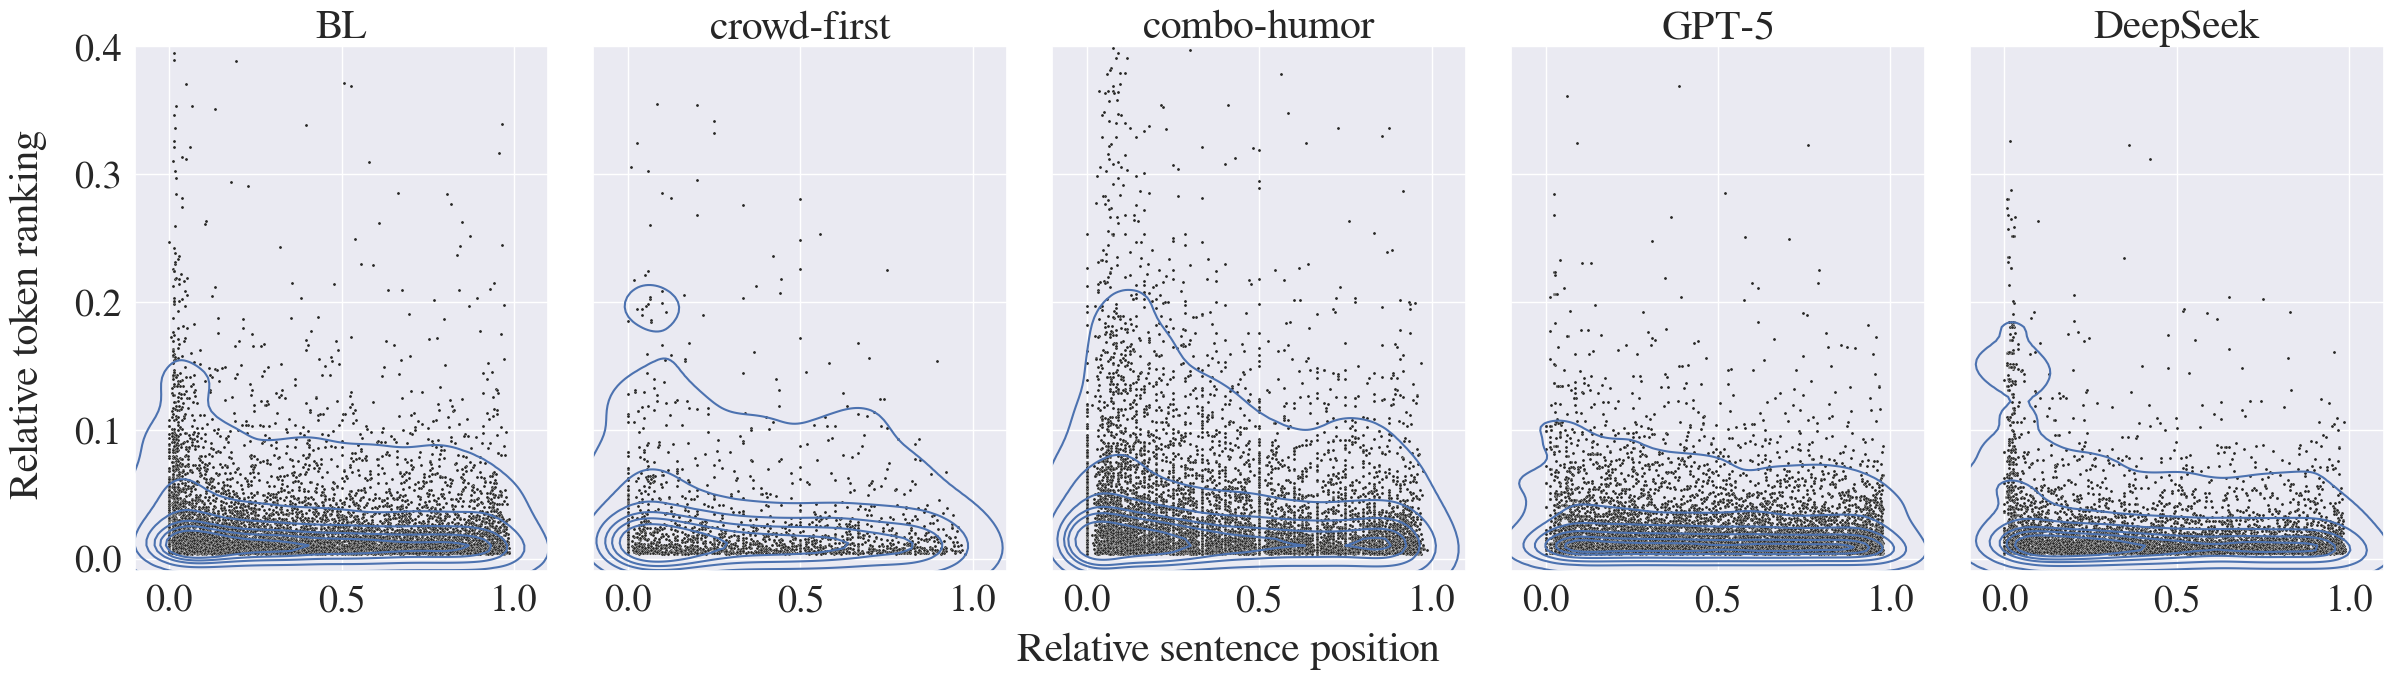

In [32]:
num_bl_tokens=len(sum(df[df.type=='BL'].ranks.values.tolist(), []))
num_comb_tokens=len(sum(df[df.type=='combo-humor'].ranks.values.tolist(), []))
num_crowd_tokens=len(sum(df[df.type=='crowd-first'].ranks.values.tolist(), []))
num_gpt5_tokens=len(sum(syn_df[syn_df.type=='gpt5'].ranks.values.tolist(), []))
num_deep_tokens=len(sum(syn_df[syn_df.type=='deep'].ranks.values.tolist(), []))


print("Fraction of outlier BL tokens: ", np.round(bull_dist.shape[0]/num_bl_tokens, 3))
print("Fraction of outlier crowd tokens: ", np.round(crowd_dist.shape[0]/num_crowd_tokens, 3))
print("Fraction of outlier comb tokens: ", np.round(comb_dist.shape[0]/num_comb_tokens, 3))
print("Fraction of outlier GPT5 tokens: ", np.round(gpt5_dist.shape[0]/num_gpt5_tokens, 3))
print("Fraction of outlier DeepSeek tokens: ", np.round(deep_dist.shape[0]/num_deep_tokens, 3))

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(1, 5, figsize=(24, 7))

# Flatten the 2D array of axes for easier iteration
axes_flat = axes.flatten()


dists = [{'name': 'BL', 'dist': bull_dist},
         {'name': 'crowd-first', 'dist': crowd_dist}, 
        {'name': 'combo-humor', 'dist': comb_dist}, 
        {'name': 'GPT-5', 'dist': gpt5_dist}, 
         # {'name': 'GPT4', 'dist': gpt4_dist},
         # {'name': 'GPT-120B', 'dist': gpt120_dist}, 
         {'name': 'DeepSeek', 'dist': deep_dist}
        ]

# Create plots in each subplot
for idx, (ax, dist) in enumerate(zip(axes_flat, dists)):
    
    sns.scatterplot(dist['dist'],x='sent-pos', y='rank', s=5, color=".15", ax=ax)
    # sns.histplot(points,x=x, y=y, bins=50, pthresh=.1, cmap="mako")
    sns.kdeplot(dist['dist'],x='sent-pos', y='rank', levels=7, linewidths=1.5,ax=ax)
    # Optional: Add title to each subplot
    ax.set_title(f"{dist['name']}")

    # Set axis limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.01,0.4)
    
    ax.set_xlabel('')    
    # Remove y ticks and labels for right column
    if idx!=0:
        ax.set_yticklabels([])
    ax.set_ylabel('')

# Add common x and y labels
# Adjust the layout
plt.tight_layout()
# Adjust margins to accommodate the common labels
# plt.subplots_adjust(left=0.05, bottom=0.1)
fig.text(0.5, 0.02, 'Relative sentence position', ha='center', va='center')
fig.text(-0.00001, 0.5, 'Relative token ranking', ha='center', va='center', rotation='vertical')
plt.savefig('surprisal-five.png', dpi=300, bbox_inches='tight')